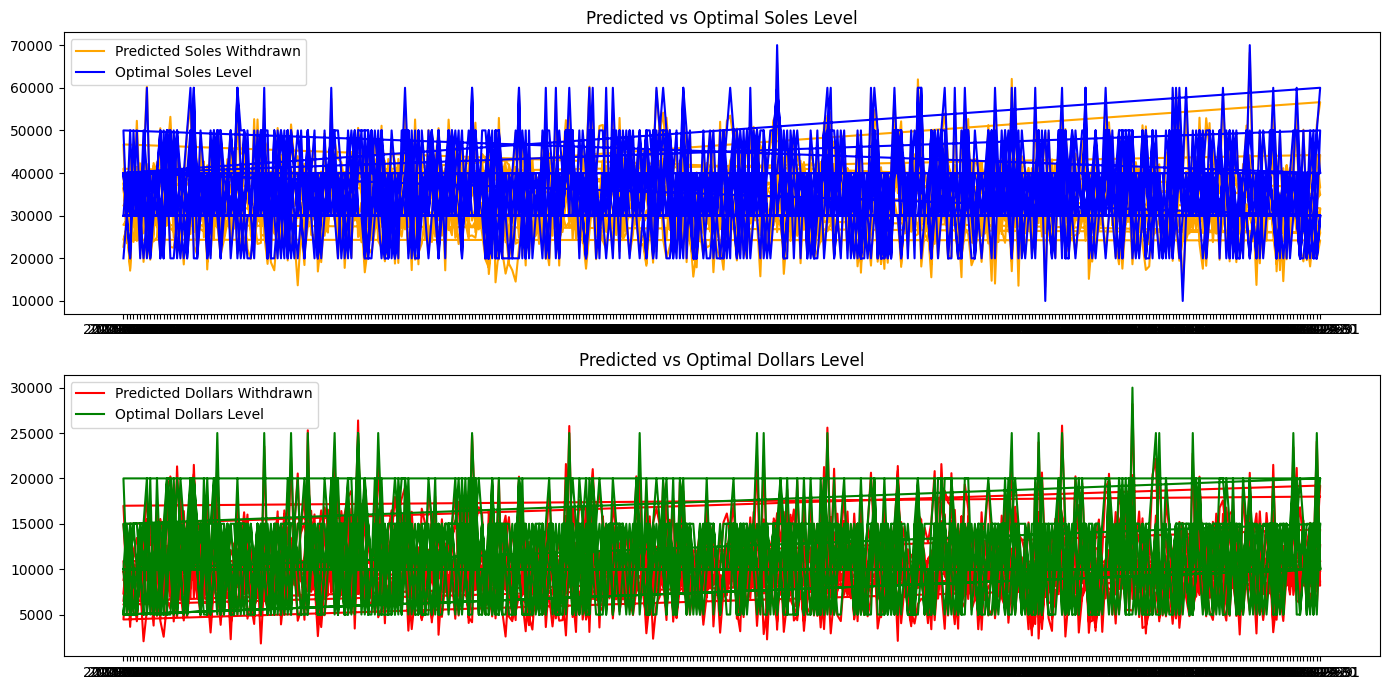

   ATM_ID        Date  Predicted_Soles_Withdrawn  Optimal_Soles_Level  \
0       1  2023-01-08                   22706.45                20000   
1       1  2023-01-09                   28769.62                30000   
2       1  2023-01-10                   17118.18                20000   
3       1  2023-01-11                   44497.24                50000   
4       1  2023-01-12                   26394.47                30000   

   Predicted_Dollars_Withdrawn  Optimal_Dollars_Level  
0                      7315.45                  10000  
1                     11668.74                  15000  
2                      3645.71                   5000  
3                      9774.27                  10000  
4                      4577.91                   5000  
Resultados optimizados guardados en: atm_dynamic_optimized_levels.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo atm_predicted_demand.csv
file_path = 'atm_predicted_demand.csv'
df = pd.read_csv(file_path)

# Suposiciones de costos
fixed_cost = 100  # Costo fijo de reabastecimiento
variable_cost = 0.1  # Costo variable asociado con el exceso de efectivo (almacenamiento y seguridad)
opportunity_cost = 0.2  # Costo de oportunidad asociado con la falta de dinero

# Capacidad máxima de cada cajero (puede ser ajustado)
max_capacity_soles = 100000  # Capacidad máxima en soles
max_capacity_dollars = 30000  # Capacidad máxima en dólares

# Variables necesarias
n_days = len(df)
states = [(soles, dollars) for soles in range(0, max_capacity_soles + 1, 10000) for dollars in range(0, max_capacity_dollars + 1, 5000)]
n_states = len(states)

# Inicializar la tabla de costos mínimos
cost_table = np.zeros((n_days, n_states))

# Función para calcular el costo en un estado particular
def calculate_cost(soles_level, dollars_level, predicted_soles, predicted_dollars):
    cost_falta_soles = max(predicted_soles - soles_level, 0) * opportunity_cost
    cost_exceso_soles = max(soles_level - predicted_soles, 0) * variable_cost
    cost_falta_dollars = max(predicted_dollars - dollars_level, 0) * opportunity_cost
    cost_exceso_dollars = max(dollars_level - predicted_dollars, 0) * variable_cost
    total_cost = cost_falta_soles + cost_exceso_soles + cost_falta_dollars + cost_exceso_dollars + fixed_cost
    return total_cost

# Programación dinámica para minimizar los costos
for day in range(n_days):
    predicted_soles = df['Predicted_Soles_Withdrawn'].iloc[day]
    predicted_dollars = df['Predicted_Dollars_Withdrawn'].iloc[day]

    for i, (soles_level, dollars_level) in enumerate(states):
        if day == 0:
            cost_table[day, i] = calculate_cost(soles_level, dollars_level, predicted_soles, predicted_dollars)
        else:
            costs = []
            for j, (prev_soles, prev_dollars) in enumerate(states):
                transition_cost = calculate_cost(soles_level, dollars_level, predicted_soles, predicted_dollars)
                costs.append(cost_table[day-1, j] + transition_cost)
            cost_table[day, i] = min(costs)

# Obtener la secuencia de niveles de efectivo que minimiza los costos
optimal_soles_levels = []
optimal_dollars_levels = []
optimal_state_idx = np.argmin(cost_table[-1])

for day in reversed(range(n_days)):
    optimal_soles_levels.append(states[optimal_state_idx][0])
    optimal_dollars_levels.append(states[optimal_state_idx][1])
    if day > 0:
        next_cost = cost_table[day, optimal_state_idx]
        optimal_state_idx = np.argmin([cost_table[day-1, j] + calculate_cost(states[optimal_state_idx][0], states[optimal_state_idx][1],
                                                                             df['Predicted_Soles_Withdrawn'].iloc[day],
                                                                             df['Predicted_Dollars_Withdrawn'].iloc[day])
                                       for j in range(n_states)])

optimal_soles_levels.reverse()
optimal_dollars_levels.reverse()

# Agregar los niveles optimizados al dataframe
df['Optimal_Soles_Level'] = optimal_soles_levels
df['Optimal_Dollars_Level'] = optimal_dollars_levels

# Visualización de los resultados

# Soles
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Predicted_Soles_Withdrawn'], label='Predicted Soles Withdrawn', color='orange')
plt.plot(df['Date'], df['Optimal_Soles_Level'], label='Optimal Soles Level', color='blue')
plt.title('Predicted vs Optimal Soles Level')
plt.legend()

# Dólares
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['Predicted_Dollars_Withdrawn'], label='Predicted Dollars Withdrawn', color='red')
plt.plot(df['Date'], df['Optimal_Dollars_Level'], label='Optimal Dollars Level', color='green')
plt.title('Predicted vs Optimal Dollars Level')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar los resultados en un nuevo archivo CSV
output_file_path = 'atm_dynamic_optimized_levels.csv'
df.to_csv(output_file_path, index=False)

# Mostrar resumen de resultados
print(df[['ATM_ID', 'Date', 'Predicted_Soles_Withdrawn', 'Optimal_Soles_Level', 'Predicted_Dollars_Withdrawn', 'Optimal_Dollars_Level']].head())

# Proporcionar un mensaje para la descarga del archivo CSV generado
print(f'Resultados optimizados guardados en: {output_file_path}')


In [2]:
# Evaluación de los resultados
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# Calcular métricas de evaluación para ambos tipos de efectivo
mae_soles = mean_absolute_error(df['Predicted_Soles_Withdrawn'], df['Optimal_Soles_Level'])
mse_soles = mean_squared_error(df['Predicted_Soles_Withdrawn'], df['Optimal_Soles_Level'])
correlation_soles, _ = pearsonr(df['Predicted_Soles_Withdrawn'], df['Optimal_Soles_Level'])

mae_dollars = mean_absolute_error(df['Predicted_Dollars_Withdrawn'], df['Optimal_Dollars_Level'])
mse_dollars = mean_squared_error(df['Predicted_Dollars_Withdrawn'], df['Optimal_Dollars_Level'])
correlation_dollars, _ = pearsonr(df['Predicted_Dollars_Withdrawn'], df['Optimal_Dollars_Level'])

print(f"Evaluación Soles - MAE: {mae_soles}, MSE: {mse_soles}, Correlación: {correlation_soles}")
print(f"Evaluación Dólares - MAE: {mae_dollars}, MSE: {mse_dollars}, Correlación: {correlation_dollars}")

Evaluación Soles - MAE: 2768.7439162011174, MSE: 11064798.479767097, Correlación: 0.943627273026068
Evaluación Dólares - MAE: 1442.586960893855, MSE: 2946052.093974414, Correlación: 0.9287590016321067


**Explicación de la evaluación:**

- **MAE (Mean Absolute Error):** Es la media del valor absoluto de las diferencias entre las demandas predichas y los valores óptimos calculados. Un MAE más bajo indica que las predicciones están más cerca de los valores óptimos.

- **MSE (Mean Squared Error):** Es la media de los cuadrados de las diferencias entre las demandas predichas y los valores óptimos calculados. Penaliza más los errores grandes que el MAE.

- **Correlación de Pearson:** Mide la correlación lineal entre las demandas predichas y los valores óptimos calculados. Un valor cercano a 1 indica una alta correlación positiva.

Estos indicadores proporcionan una idea de qué tan bien se están optimizando los valores con respecto a las demandas predichas, y la visualización nos permitirá comparar visualmente los resultados.